# LangGraph
## Quick Start
- https://langchain-ai.github.io/langgraph/tutorials/introduction/

### Enhancing the Chatbot with Tools

In [1]:
!uv pip install -r requirements.txt

Audited 10 packages in 6ms


In [5]:
# ######################################
# Load Environment Variables
# ######################################

import os
from typing import Annotated, TypedDict
from dotenv import load_dotenv

load_dotenv()

os.environ["AZURE_API_KEY"] = os.environ["AZURE_OPENAI_API_KEY"]
os.environ["AZURE_API_BASE"] = os.environ["AZURE_OPENAI_ENDPOINT"]
os.environ["AZURE_API_VERSION"] = os.environ["AZURE_OPENAI_API_VERSION"]
os.environ["AZURE_API_MODEL"] = os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"]


In [6]:

# ######################################
# A tool; Tavily Search
# ######################################

from langchain_community.tools.tavily_search import TavilySearchResults

tool_tavily_search = TavilySearchResults(max_results=2)
tool_tavily_search.invoke("What's a 'node' in LangGraph?")

tools = [tool_tavily_search]


In [7]:
# ######################################
# Bind model with tools
# ######################################

from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(api_version=os.environ["AZURE_API_VERSION"], model=os.environ["AZURE_API_MODEL"])   # Uses Azure config from environment variables
llm_with_tools = llm.bind_tools(tools)


In [ ]:
# ######################################
# Agent
# ######################################

from langgraph.graph.message import add_messages
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


def agent(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}



In [ ]:
# ######################################
# Graph
# ######################################

from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=[tool_tavily_search])

graph_builder = StateGraph(State)
graph_builder.add_node("agent", agent)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("agent", tools_condition)
graph_builder.add_edge("tools", "agent")
graph_builder.set_entry_point("agent")
graph = graph_builder.compile()


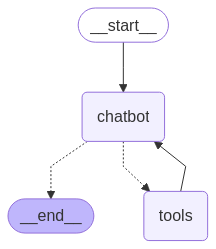

In [ ]:
# ######################################
# Graph
# ######################################

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# ######################################
# Run
# ######################################

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break


Assistant: Hello! How can I assist you today?
Assistant: 
Assistant: [{"title": "Dow Jones INDEX TODAY | DJIA LIVE TICKER - Markets Insider", "url": "https://markets.businessinsider.com/index/dow_jones", "content": "Name | Previous Close | Last | % | +/- | Trade Time\n3M | 138.64 | 141.12 | 1.79% | 2.48 | 04:15:00 PM\nAmazon | 188.71 | 192.08 | 1.79% | 3.37 | 08:00:00 PM\nAmerican Express | 276.24 | 283.66 | 2.69% | 7.42 | 04:15:00 PM\nAmgen | 275.84 | 272.05 | -1.37% | -3.79 | 08:00:00 PM\nApple | 196.25 | 197.49 | 0.63% | 1.24 | 08:00:00 PM\nBoeing | 185.56 | 191.70 | 3.31% | 6.14 | 04:15:00 PM\nCaterpillar | 320.29 | 324.25 | 1.24% | 3.96 | 04:15:00 PM\nChevron | 135.79 | 137.04 | 0.92% | 1.25 | 04:15:00 PM [...] | 30 Days | 90 Days | 250 Days\nPerformance | 1.87 % | -6.98 % | 1.05 %\nHigh | 41,445.91 | 44,769.05 | 45,073.63\nLow | 37,275.69 | 36,611.78 | 36,611.78\nVolatility | 34.54 | 27.00 | 18.96\nBiggest Gainers\n\nBiggest Losers\n\nMarket Cap\n\nName | Market Cap in M\nS&P 500